In [1]:
!nvidia-smi

Sat Jul 13 10:55:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 538.18                 Driver Version: 538.18       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro M1000M                WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0              N/A / 200W |      0MiB /  4096MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import torch

# Check PyTorch GPU availability
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Is Available: {torch.cuda.is_available()}")
else:
    print("GPU is not available.")

GPU is not available.


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [5]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            img = load_img(os.path.join(folder, filename), target_size=(256, 256))
            img = img_to_array(img)
            img = np.expand_dims(img, axis=0)
            img = img / 255.0
            images.append(img)
            labels.append(1 if 'yes' in folder else 0)
    return np.vstack(images), np.array(labels)

In [20]:
yes_folder = "..\\MRI Images\\brain_tumor_dataset\\yes"
no_folder = "..\\MRI Images\\brain_tumor_dataset\\no"

In [21]:
yes_images, yes_labels = load_images_from_folder(yes_folder)
no_images, no_labels = load_images_from_folder(no_folder)

In [22]:
MRI_images = np.concatenate((yes_images, no_images), axis=0)
y_mri_labels = np.concatenate((yes_labels, no_labels), axis=0)

In [23]:
X_train_mri, X_val_mri, y_train_mri, y_val_mri = train_test_split(MRI_images, y_mri_labels, test_size=0.2, random_state=42)

In [24]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [25]:
def train_model(model, X_train, y_train, X_val, y_val, learning_rate, batch_size, epochs):
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))
    return history

In [26]:
def evaluate_model(model, X_val, y_val):
    y_pred = (model.predict(X_val) > 0.5).astype("int32")
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc_roc = roc_auc_score(y_val, y_pred)
    return accuracy, precision, recall, f1, auc_roc

In [27]:
base_models = {
    'ResNet50': ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    'DenseNet121': DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3)),
    'InceptionV3': InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
}

In [28]:
learning_rates = [0.001, 0.01, 0.1]
batch_sizes = [8, 16, 32]
epochs = 3
results = {}

In [29]:
for model_name, base_model in base_models.items():
    for lr in learning_rates:
        for batch_size in batch_sizes:
            print(f"Training {model_name} with LR={lr}, Batch Size={batch_size}")
            model = build_model(base_model)
            history = train_model(model, X_train_mri, y_train_mri, X_val_mri, y_val_mri, lr, batch_size, epochs)
            metrics = evaluate_model(model, X_val_mri, y_val_mri)
            results[f"{model_name}mri_lr{lr}batch{batch_size}"] = metrics

Training ResNet50 with LR=0.001, Batch Size=8
Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.6105 - loss: 2.1363 - val_accuracy: 0.4286 - val_loss: 624.4586
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.6049 - loss: 0.6974 - val_accuracy: 0.5714 - val_loss: 2181.8074
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6530 - loss: 0.6053 - val_accuracy: 0.5714 - val_loss: 411.3811
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training ResNet50 with LR=0.001, Batch Size=16
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 111s 5s/step - accuracy: 0.5812 - loss: 1.2626 - val_accuracy: 0.5714 - val_loss: 114617.2109
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.7385 - loss: 0.6627 - val_accuracy: 0.5714 - val_loss: 895799.6875
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.8033 - loss: 0.4640 - val_accuracy: 0.5714 - val_loss: 2272.6616
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training ResNet50 with LR=0.001, Batch Size=32
Epoch 1/3
5/5 ━━━━━━━━━

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 108s 3s/step - accuracy: 0.5499 - loss: 19.3410 - val_accuracy: 0.4286 - val_loss: 53856230173212409856.0000
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.4979 - loss: 0.7970 - val_accuracy: 0.4286 - val_loss: 1033731047424.0000
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5133 - loss: 0.6948 - val_accuracy: 0.4286 - val_loss: 98938584.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step
Training ResNet50 with LR=0.1, Batch Size=16


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.5887 - loss: 38.6704 - val_accuracy: 0.4286 - val_loss: 1098721525760.0000
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.4073 - loss: 15.0657 - val_accuracy: 0.5714 - val_loss: 1063326976.0000
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5857 - loss: 2.1607 - val_accuracy: 0.4286 - val_loss: 554121536.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step
Training ResNet50 with LR=0.1, Batch Size=32
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step - accuracy: 0.4314 - loss: 21.2078 - val_accuracy: 0.5714 - val_loss: 21881206.0000
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.6248 - loss: 1.4940 - val_accuracy: 0.4286 - val_loss: 13494269.0000
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.6583 - loss: 0.8035 - val_accuracy: 0.4286 - val_loss: 191761696.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Training DenseNet121 with LR=0.001, Batch Size=8
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.6557 - loss: 1.1685 - val_accuracy: 0.5714 - val_loss: 20.4634
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7048 - loss: 0.5563 - val_accuracy: 0.5714 - val_loss: 27.0474
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.8176 - loss: 0.4131 - val_accuracy: 0.5714 - val_loss: 18.9401
2/2 ━━━━━━━━━━━━━━━━━━━━ 15s 9s/step
Training DenseNet121 with LR=0.001, Batch Size=16
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 193s 6s/step - accuracy: 0.5673 - loss: 0.8404 - val_accuracy: 0.5714 - val_loss: 1576.5553
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step - accuracy: 0.8262 - loss: 0.4323 - val_accuracy: 0.5714 - val_loss: 156.9688
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8351 - loss: 0.5071 - val_accuracy: 0.4286 - val_loss: 243.6891
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 11s/step
Training DenseNet121 with LR=0.001, Batch Size=32
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 152s 9s/step - accuracy: 0.8334 - loss: 0.6031 - val_accuracy: 0.5714 - val_loss: 306.9310
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 9s/step - accuracy: 0.8925 - loss: 0.3524 - val_accuracy: 0.5714 - val_loss: 1055.1859
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 41s 8s/step - accuracy: 0.9492 - loss: 0.2001 - val_accuracy: 0.5714 - val_loss: 1491.5920
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
Training DenseNet121 with LR=0.01, Batch Size=8
Epoch 1/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.4335 - loss: 9.1487 - val_accuracy: 0.5714 - val_loss: 12296132666325421334200320.0000
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.4456 - loss: 0.7450 - val_accuracy: 0.4286 - val_loss: 21455562814259200.0000
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5931 - loss: 0.7428 - val_accuracy: 0.4286 - val_loss: 54429241344.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 11s/step
Training DenseNet121 with LR=0.01, Batch Size=16
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.5412 - loss: 2.2596 - val_accuracy: 0.5714 - val_loss: 30642643402752.0000
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 51s 6s/step - accuracy: 0.5329 - loss: 2.8204 - val_accuracy: 0.5714 - val_loss: 9021862273089536.0000
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 53s 6s/step - accuracy: 0.5769 - loss: 3.1875 - val_accuracy: 0.5714 - val_loss: 19140708401152.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step
Training DenseNet121 with LR=0.01, Batch Size=32
Epoch 1/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 166s 10s/step - accuracy: 0.4672 - loss: 4.4560 - val_accuracy: 0.4286 - val_loss: 209410272.0000
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.5519 - loss: 0.7434 - val_accuracy: 0.4286 - val_loss: 107856360.0000
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 45s 9s/step - accuracy: 0.5004 - loss: 0.8564 - val_accuracy: 0.4286 - val_loss: 6621785.5000
2/2 ━━━━━━━━━━━━━━━━━━━━ 13s 6s/step
Training DenseNet121 with LR=0.1, Batch Size=8
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.5732 - loss: 105.1456 - val_accuracy: 0.4286 - val_loss: 0.7259
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5818 - loss: 1.2204 - val_accuracy: 0.4286 - val_loss: 28838951084454488047616.0000
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step - accuracy: 0.5237 - loss: 1.3139 - val_accuracy: 0.5714 - val_loss: 113898850091008.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 5s/step
Training DenseNet121 with LR=0.1, Batch Size=16
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 151s 6s/step - accuracy: 0.5309 - loss: 3.0650 - val_accuracy: 0.5714 - val_loss: 533327529621061632.0000
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.4555 - loss: 3.1687 - val_accuracy: 0.5714 - val_loss: 2209184502211254681600.0000
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 50s 6s/step - accuracy: 0.5336 - loss: 0.9096 - val_accuracy: 0.5714 - val_loss: 930804322828655001600.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 13s/step
Training DenseNet121 with LR=0.1, Batch Size=

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.4916 - loss: 1.8093 - val_accuracy: 0.5429 - val_loss: 4.8681
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.8266 - loss: 0.4141 - val_accuracy: 0.4571 - val_loss: 63.6799
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.8163 - loss: 0.4207 - val_accuracy: 0.4286 - val_loss: 13.2837
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training InceptionV3 with LR=0.001, Batch Size=16
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


9/9 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.5701 - loss: 0.7275 - val_accuracy: 0.4286 - val_loss: 8026.0044
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step - accuracy: 0.7522 - loss: 0.6477 - val_accuracy: 0.4286 - val_loss: 4355.5435
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.7040 - loss: 0.5611 - val_accuracy: 0.4286 - val_loss: 18209.4473
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training InceptionV3 with LR=0.001, Batch Size=32
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.4830 - loss: 0.7538 - val_accuracy: 0.4286 - val_loss: 17998928.0000
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - accuracy: 0.6160 - loss: 0.6062 - val_accuracy: 0.4286 - val_loss: 89647584.0000
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 34s 7s/step - accuracy: 0.7981 - loss: 0.7473 - val_accuracy: 0.4286 - val_loss: 48167688.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training InceptionV3 with LR=0.01, Batch Size=8
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.5119 - loss: 3.5281 - val_accuracy: 0.4286 - val_loss: 449859198487283019808768.0000
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.4803 - loss: 3.0606 - val_accuracy: 0.5714 - val_loss: 2139010348613632.0000
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.5823 - loss: 0.8679 - val_accuracy: 0.5714 - val_loss: 678751371264.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training InceptionV3 with LR=0.01, Batch Size=16
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.5243 - loss: 1.6934 - val_accuracy: 0.5714 - val_loss: 9877897.0000
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5145 - loss: 0.7780 - val_accuracy: 0.5714 - val_loss: 54664000.0000
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 40s 5s/step - accuracy: 0.5576 - loss: 0.6745 - val_accuracy: 0.5714 - val_loss: 33034280.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training InceptionV3 with LR=0.01, Batch Size=32
Epoch 1/3
5/5 ━━━━━━━━━━━━

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


18/18 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.4575 - loss: 11.4957 - val_accuracy: 0.5714 - val_loss: 5507899595495047168.0000
Epoch 2/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.5234 - loss: 0.7074 - val_accuracy: 0.5714 - val_loss: 2774620176384.0000
Epoch 3/3
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.4583 - loss: 0.6948 - val_accuracy: 0.4857 - val_loss: 18498196.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
Training InceptionV3 with LR=0.1, Batch Size=16
Epoch 1/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.4950 - loss: 15.3934 - val_accuracy: 0.5714 - val_loss: 9251245260800.0000
Epoch 2/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - accuracy: 0.5610 - loss: 6.5859 - val_accuracy: 0.5714 - val_loss: 158282278764544.0000
Epoch 3/3
9/9 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/step - accuracy: 0.5220 - loss: 2.7016 - val_accuracy: 0.4286 - val_loss: 510351179776.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step
Training InceptionV3 with LR=0.1, Batch Size=32
Epoch 1/3


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step - accuracy: 0.4713 - loss: 4.3341 - val_accuracy: 0.5714 - val_loss: 246065807360.0000
Epoch 2/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 30s 6s/step - accuracy: 0.4914 - loss: 0.8606 - val_accuracy: 0.5714 - val_loss: 89326632960.0000
Epoch 3/3
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 6s/step - accuracy: 0.5467 - loss: 0.9106 - val_accuracy: 0.5714 - val_loss: 210973671424.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step


In [30]:
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC']).T

In [31]:
print(results_df)

                               Accuracy  Precision  Recall  F1-score   AUC-ROC
ResNet50mri_lr0.001batch8      0.571429   0.571429     1.0  0.727273  0.500000
ResNet50mri_lr0.001batch16     0.571429   0.571429     1.0  0.727273  0.500000
ResNet50mri_lr0.001batch32     0.571429   0.571429     1.0  0.727273  0.500000
ResNet50mri_lr0.01batch8       0.571429   0.571429     1.0  0.727273  0.500000
ResNet50mri_lr0.01batch16      0.571429   0.571429     1.0  0.727273  0.500000
ResNet50mri_lr0.01batch32      0.428571   0.000000     0.0  0.000000  0.500000
ResNet50mri_lr0.1batch8        0.428571   0.000000     0.0  0.000000  0.500000
ResNet50mri_lr0.1batch16       0.428571   0.000000     0.0  0.000000  0.500000
ResNet50mri_lr0.1batch32       0.428571   0.000000     0.0  0.000000  0.500000
DenseNet121mri_lr0.001batch8   0.571429   0.571429     1.0  0.727273  0.500000
DenseNet121mri_lr0.001batch16  0.428571   0.000000     0.0  0.000000  0.500000
DenseNet121mri_lr0.001batch32  0.571429   0.571429  

In [32]:
def plot_roc_curve(model, X_val, y_val, model_name):
    y_pred_prob = model.predict(X_val).ravel()
    fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


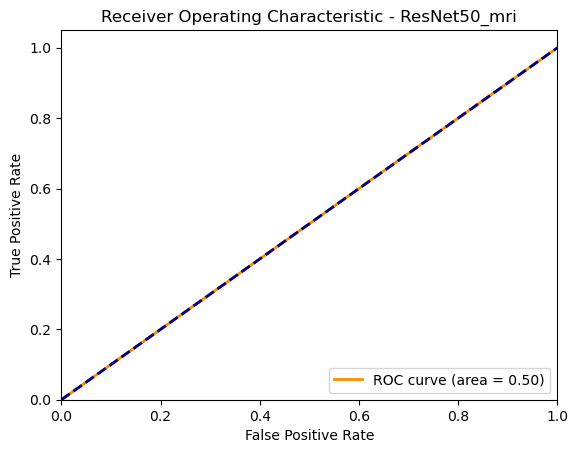

In [33]:

# Example plotting for one model
plot_roc_curve(model, X_val_mri, y_val_mri, "ResNet50_mri")